# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**План по выполнению проекта:**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import re
import tqdm
from tqdm.notebook import tqdm
import nltk
import en_core_web_sm
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

Загрузим наш файл

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

Напишем функцию для просмотра наших данных

In [3]:

def first_look (df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print ('Первые 5 строк')
    display(df.head())
    print('')
    print('')
    print ('Типы данных-')
    print (df.info())
    print('')
    print('')
    print ('Пропуски')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2),\
                  '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
    print ('Дубликаты')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    min_unique = limit_na_category + 1
    for element in df._get_numeric_data().columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('Категориальные признаки')
    for element in df._get_numeric_data().columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

Взглянем на наши данные

In [4]:
first_look(df)

------------- Первые 5 строк ------------


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ


------------- Категориальные признаки ------------
toxic :  2 категории -  [0 1]


Наши данные состоят из двух столбцов. Столбкец 'text' содержит текст комментария, а столбец 'toxic' - целевой признак
Посмотрим на распределение целевого признака

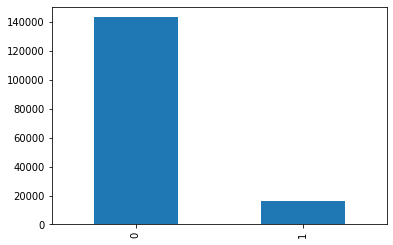

In [5]:
df['toxic'].value_counts().plot(kind='bar');

* Наблюдаем явный дисбаланс классов
* Нам необходимо ощистить текст от нежелательных символом и лемматизировать его

Создадим функцию очистки текста от нежелательных символов

In [6]:
def clear_text(text):
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text).strip()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
        
    return text

Очистим текст от нежелательных символов

In [7]:
df['text'] = df['text'].apply(clear_text)
display(df.head())

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour m seem...,0
2,hey man m really not trying to edit war it jus...,0
3,more can make any real suggestions on improvem...,0
4,you sir are my hero any chance you remember wh...,0


Для токенизации и лемматизации воспользуемся моделью en_core_web_sm, т.к. ни pymystem3 ни WordNetLemmatizer не дали результата из-за постоянного падения ядра системы

In [8]:
nlp = en_core_web_sm.load()

def lemmatize(text):
    temp = []
    for i in nlp(text):
        if i.is_stop == False:
            temp.append(i.lemma_)
    return " ".join(temp)


tqdm.pandas()
df['text'] = df['text'].progress_apply(lemmatize)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [9]:
df.head()

,text,toxic
0,explanation edit username hardcore metallica f...,0
1,d aww match background colour m seemingly stuc...,0
2,hey man m try edit war guy constantly remove r...,0
3,real suggestion improvement wonder section sta...,0
4,sir hero chance remember page,0


Сохраним наши данные для последующего пропуска шага лемматизации

In [10]:
dump(df, 'toxic_comments_lemmas.csv')

['toxic_comments_lemmas.csv']

Загрузим наши данные сохраненные после лемматизации

In [11]:
df = load('toxic_comments_lemmas.csv')

* На данном шаге мы просмотрели наши данные, очистили их и лемматизировали.

## Обучение

Разобьем наши данные на обучающую и тестовую выборки в соотношении 75:25

In [12]:
features = df['text']
target = df['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Создадим признаки с учетом стоп-слов и выделим целевые признаки

In [13]:
# Загрузим стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

# Создадим счетчик, указав в нем стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
# Посчитаем TD-IDF для корпуса текстов
tf_idf = count_tf_idf.fit(features_train)
# Создадим признаки
features_train = tf_idf.transform(features_train)
features_test = tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функция обучения наших моделей, поиска наилучшей метрики f1 и подобранных параметров

In [14]:
def model_look (model, parameters, features, target):
    model_grid = GridSearchCV(model, parameters, cv=5, scoring='f1', verbose=5)
    model_grid.fit(features, target)
    return model_grid.best_score_, model_grid.best_params_

### Логистическая регрессия

In [15]:
parameters = {'C': range(23, 26, 1), 'max_iter': range(8, 10, 1)}
f1, best_parameters = model_look (LogisticRegression(random_state=12345, solver='liblinear'), parameters, features_train, target_train)
display('Лучшие параметры модели линейной регрессии:', best_parameters)
display('Дали f1 модели:', f1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5] END ...............................C=23, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5] END ...............................C=23, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5] END ...............................C=23, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5] END ...............................C=23, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5] END ...............................C=23, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5] END ...............................C=23, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5] END ...............................C=23, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5] END ...............................C=23, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5] END ...............................C=23, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5] END ...............................C=23, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5] END ...............................C=24, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5] END ...............................C=24, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5] END ...............................C=24, max_iter=8; total time=   5.2s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5] END ...............................C=24, max_iter=8; total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5] END ...............................C=24, max_iter=8; total time=   5.2s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5] END ...............................C=24, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5] END ...............................C=24, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5] END ...............................C=24, max_iter=9; total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5] END ...............................C=24, max_iter=9; total time=   6.6s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5] END ...............................C=24, max_iter=9; total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5] END ...............................C=25, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5] END ...............................C=25, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5] END ...............................C=25, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5] END ...............................C=25, max_iter=8; total time=   5.2s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5] END ...............................C=25, max_iter=8; total time=   5.3s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5] END ...............................C=25, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5] END ...............................C=25, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5] END ...............................C=25, max_iter=9; total time=   6.6s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5] END ...............................C=25, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5] END ...............................C=25, max_iter=9; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


'Лучшие параметры модели линейной регрессии:'

{'C': 25, 'max_iter': 8}

'Дали f1 модели:'

0.7734854354110138

In [16]:
results = pd.DataFrame ({'model':['LogisticRegression'], 'best_parameters_train':[best_parameters], 'f1_train':[f1]})
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.773485


### Дерево решений

In [17]:
parameters = {'max_depth': range(122, 124, 1)}
f1, best_parameters = model_look (DecisionTreeClassifier(random_state=12345), parameters, features_train, target_train)
display('Лучшие параметры модели дерева решений:', best_parameters)
display('Дали f1 модели:', f1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ..................................max_depth=122; total time=  45.4s
[CV 2/5] END ..................................max_depth=122; total time=  45.0s
[CV 3/5] END ..................................max_depth=122; total time=  45.2s
[CV 4/5] END ..................................max_depth=122; total time=  46.6s
[CV 5/5] END ..................................max_depth=122; total time=  44.6s
[CV 1/5] END ..................................max_depth=123; total time=  45.7s
[CV 2/5] END ..................................max_depth=123; total time=  44.7s
[CV 3/5] END ..................................max_depth=123; total time=  45.1s
[CV 4/5] END ..................................max_depth=123; total time=  46.2s
[CV 5/5] END ..................................max_depth=123; total time=  44.9s


'Лучшие параметры модели дерева решений:'

{'max_depth': 123}

'Дали f1 модели:'

0.7272793577738383

In [18]:
results = results.append({'model':'DecisionTreeClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.773485
1,DecisionTreeClassifier,{'max_depth': 123},0.727279


### Cлучайный лес

In [19]:
parameters = {'max_depth': range(213, 216, 1), 'n_estimators': range(3, 6, 1)}
f1, best_parameters = model_look (RandomForestClassifier(random_state=12345), parameters, features_train, target_train)
display('Лучшие параметры модели случайного леса:', best_parameters)
display('Дали f1 модели:', f1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..................max_depth=213, n_estimators=3; total time=  11.1s
[CV 2/5] END ..................max_depth=213, n_estimators=3; total time=  10.9s
[CV 3/5] END ..................max_depth=213, n_estimators=3; total time=  10.6s
[CV 4/5] END ..................max_depth=213, n_estimators=3; total time=  10.6s
[CV 5/5] END ..................max_depth=213, n_estimators=3; total time=  10.8s
[CV 1/5] END ..................max_depth=213, n_estimators=4; total time=  14.9s
[CV 2/5] END ..................max_depth=213, n_estimators=4; total time=  14.7s
[CV 3/5] END ..................max_depth=213, n_estimators=4; total time=  14.2s
[CV 4/5] END ..................max_depth=213, n_estimators=4; total time=  14.2s
[CV 5/5] END ..................max_depth=213, n_estimators=4; total time=  14.6s
[CV 1/5] END ..................max_depth=213, n_estimators=5; total time=  18.5s
[CV 2/5] END ..................max_depth=213, n_e

'Лучшие параметры модели случайного леса:'

{'max_depth': 213, 'n_estimators': 4}

'Дали f1 модели:'

0.5565125819039631

In [20]:
results = results.append({'model':'RandomForestClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.773485
1,DecisionTreeClassifier,{'max_depth': 123},0.727279
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.556513


* На данном этапе мы обучили наши данные моделями машинного обучения и выявили оптимальные гиперпараметры для этих моделей. Проверим полученные значения на тестовых данных

## Тестирование моделей

Функция обучения моделей на тестовой выборке и занесения результата метрики f1 в таблицу

In [21]:
def ml_result(model, features_train, target_train, features_test, target_test):
        
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_test)
    
    f1 = f1_score(target_test, predictions)
      
    return f1

### Логистическая регрессия

In [22]:
f1 = ml_result(LogisticRegression(
    random_state=12345, solver='liblinear', C=24, max_iter=8), features_train, target_train, features_test, target_test
              )
results.loc[0, 'f1_test'] = f1
results

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.773485,0.78558
1,DecisionTreeClassifier,{'max_depth': 123},0.727279,NaN
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.556513,NaN


### Дерево решений

In [23]:
f1 = ml_result(DecisionTreeClassifier(
    random_state=12345, max_depth=123), features_train, target_train, features_test, target_test
              )
results.loc[1, 'f1_test'] = f1
results

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.773485,0.785580
1,DecisionTreeClassifier,{'max_depth': 123},0.727279,0.728012
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.556513,NaN


### Cлучайный лес

In [24]:
f1 = ml_result(RandomForestClassifier(
    random_state=12345, max_depth=213, n_estimators=4), features_train, target_train, features_test, target_test
              )
results.loc[2, 'f1_test'] = f1
results

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.773485,0.785580
1,DecisionTreeClassifier,{'max_depth': 123},0.727279,0.728012
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.556513,0.586759


* На данном этапе мы обучили модели машинного обучения на тренировочной выборке и проверили их на тестовой выборке. Лучшими характеристиками по условиям задачи себя показала модель логистической регрессии.

## Выводы

По итогу данного проекта было выполнено:
* Подготовили исходные данные: лемматизировали и токенизировали данные, а также избавились от нежелательных символов;
* Обучили модели;
* Проверели модели на тестовой выборке и выбрали самую оптимальную из них.


Согласно условиям задачи модель логистической регрессии лучше всех справилась с выполнением своей задачи в виду: 
* Более точного предсказания;
* Меньшего времени как обучения, так и предсказаний.